# Garbage Classification

### Preparations

In [1]:
# !python chapter_setup.py

### Loading Libraries

In [4]:
# Install the missing library
!apt-get update && apt-get install -y libgl1-mesa-glx

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]
Get:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [2683 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1599 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [36.8 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [4919 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [4998 kB]
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 Packages [34.8 kB]
Get:

In [7]:
!!pip install --upgrade scipy

['Collecting scipy',
 '  Using cached scipy-1.15.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.7 MB)',
 'Requirement already satisfied: numpy<2.5,>=1.23.5 in /toolkit-cache/0.2.23/python3.10/kernel-libs/lib/python3.10/site-packages (from scipy) (1.26.4)',
 'Installing collected packages: scipy',
 'Successfully installed scipy-1.15.3',
 '',
 '\x1b[\x1b\x1bnotice\x1b\x1b[1;39;49m]\x1b\x1b A new release of pip is available: \x1b\x1b23.0.1\x1b\x1b -> \x1b\x1b25.1.1\x1b',
 '\x1b[\x1b\x1bnotice\x1b\x1b[1;39;49m]\x1b\x1b To update, run: \x1b\x1bpip install --upgrade pip\x1b']

In [28]:
!pip install pytorch_lightning==2.5.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 751.2/751.2 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.1/326.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.6/226.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.9/222.9 kB 8.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [43]:
# Numerical Computing
import math
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable 
from matplotlib.colors import LinearSegmentedColormap

# OS & Random
import os, gc
import random

# Datasets Source
import machine_learning_datasets as mldatasets

# Scikit-Learn
from sklearn.preprocessing import OneHotEncoder

# PyTorch
import torchvision
import torch
import pytorch_lightning as pl
import efficientnet_pytorch
from torchinfo import summary

# Computer Vision
import cv2

# Notebook Optimizer
from tqdm.notebook import tqdm

# Captum
from captum import attr

/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Understanding & Preparing Data

In [46]:
%%time
dataset_file = "garbage_dataset_sample"
dataset_url = f"https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python-2E/raw/main/datasets/{dataset_file}.zip"
torchvision.datasets.utils.download_url(dataset_url, ".")
torchvision.datasets.utils.extract_archive(f"{dataset_file}.zip", remove_finished=True)

24.7%Downloading https://media.githubusercontent.com/media/PacktPublishing/Interpretable-Machine-Learning-with-Python-2E/main/datasets/garbage_dataset_sample.zip to ./garbage_dataset_sample.zip
100.0%
CPU times: user 2.46 s, sys: 1.38 s, total: 3.84 s
Wall time: 18min 37s


''

In [48]:
norm_mean = (0.485, 0.456, 0.406)
norm_std  = (0.229, 0.224, 0.225)

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(norm_mean, norm_std),
    ]
)

train_data = torchvision.datasets.ImageFolder(f"{dataset_file}/train", transform)
val_data = torchvision.datasets.ImageFolder(f"{dataset_file}/validation", transform)
test_data = torchvision.datasets.ImageFolder(f"{dataset_file}/test", transform)
test_400_data = torchvision.datasets.ImageFolder(f"{dataset_file}/test_400", transform)

In [49]:
print(f"# Training Samples:    \t{len(train_data)}")
print(f"# Validation Samples:  \t{len(val_data)}")
print(f"# Test Samples:        \t{len(test_data)}")
print(f"Sample Dimension:      \t{test_data[0][0].shape}")
print("="*50)
print(f"# Test 400 Samples:    \t{len(test_400_data)}")
print(f"# 400 Sample Dimension:\t{test_400_data[0][0].shape}")

# Training Samples:    	3724
# Validation Samples:  	931
# Test Samples:        	120
Sample Dimension:      	torch.Size([3, 224, 224])
# Test 400 Samples:    	120
# 400 Sample Dimension:	torch.Size([3, 400, 400])


- Data Preparation

In [52]:
labels_l = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass',\
            'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

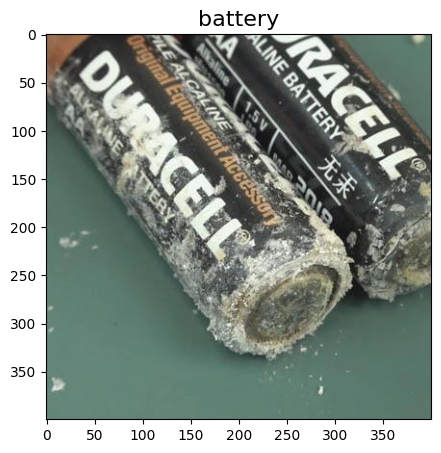

In [55]:
tensor, label = test_400_data[0]

img = mldatasets.tensor_to_img(tensor, norm_std, norm_mean)

plt.figure(figsize=(5,5))
plt.title(labels_l[label], fontsize=16)
plt.imshow(img)
plt.show()

In [ ]:
# y_test = np.array([l for _, l in test_data])
# y_val = np.array([l for _, l in val_data])

# ohe = OneHotEncoder(sparse=False).\
#               fit(np.array(y_test).reshape(-1, 1))

In [61]:
from sklearn.preprocessing import OneHotEncoder

y_test = np.array([l for _, l in test_data])
y_val = np.array([l for _, l in val_data])

ohe = OneHotEncoder(sparse_output=False).\
              fit(np.array(y_test).reshape(-1, 1))

In [64]:
rand = 42

os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)
random.seed(rand)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == 'cuda':
    torch.cuda.manual_seed(rand)
else:
    torch.manual_seed(rand)

- Inspecting Data

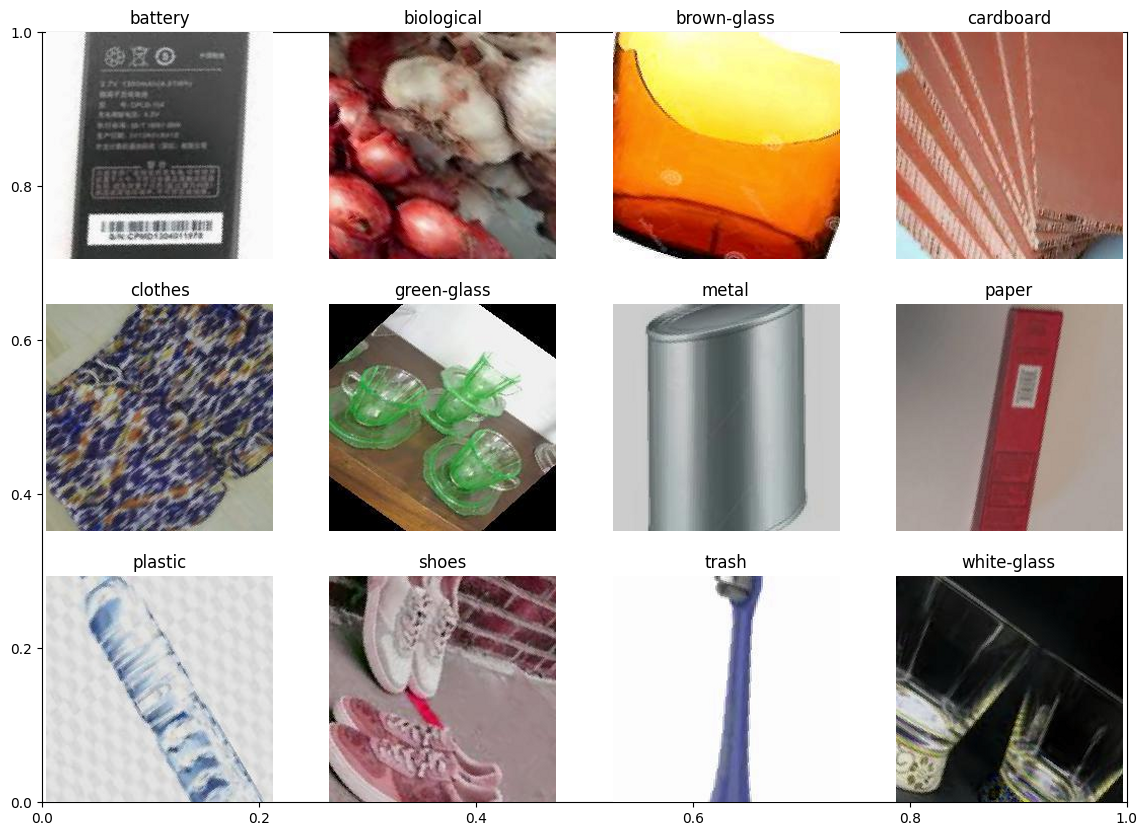

In [67]:
plt.subplots(figsize=(14,10))

for c, category in enumerate(labels_l):
    plt.subplot(3, 4, c+1)
    plt.title(labels_l[c], fontsize=12)
    idx = np.random.choice(np.where(y_val==c)[0], 1)[0]
    im = mldatasets.tensor_to_img(val_data[idx][0], norm_std, norm_mean)
    plt.imshow(im, interpolation='spline16')
    plt.axis("off")

plt.show()

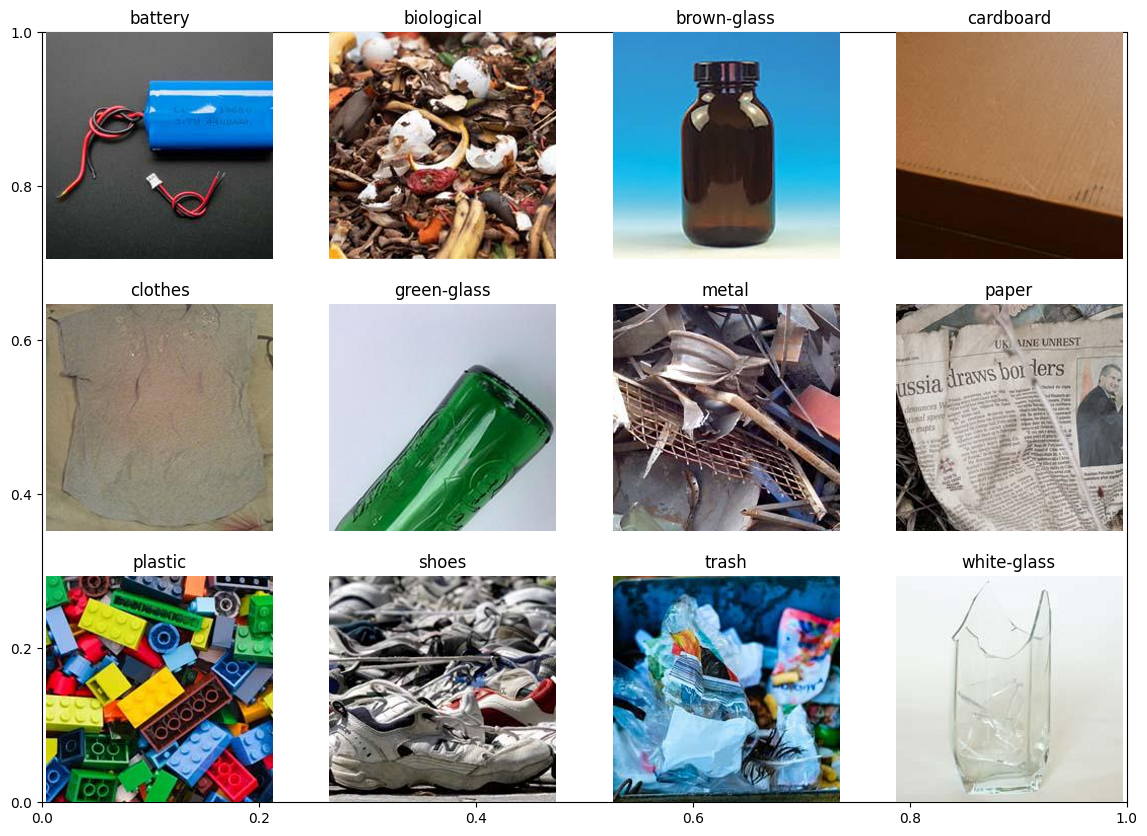

In [70]:
plt.subplots(figsize=(14,10))
for c, category in enumerate(labels_l):
    plt.subplot(3, 4, c+1)
    plt.title(labels_l[c], fontsize=12)
    idx = np.random.choice(np.where(y_test==c)[0], 1)[0]
    im = mldatasets.tensor_to_img(test_data[idx][0], norm_std, norm_mean)
    plt.imshow(im, interpolation='spline16')
    plt.axis("off")
plt.show()

### Loading CNN Model

In [73]:
def print_gpu_mem_used():
    if torch.cuda.is_available():
        mem_info = torch.cuda.mem_get_info()
        mem_info_pct = 1 - (mem_info[0]/mem_info[1])
        print(f"GPU Mem Used:\t{mem_info_pct:.2%}")

def clear_gpu_cache():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [ ]:
# if you are using a GPU
# print(torch.cuda.memory_summary())

In [79]:
# Checking GPU memory summary
if torch.cuda.is_available():
    print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [82]:
class EfficientLite(pl.LightningModule):
    def __init__(self, lr: float, num_class: int, pretrained="efficientnet-b0", *args, **kwargs):
        super().__init__()

        self.save_hyperparameters()
        self.model = efficientnet_pytorch.EfficientNet.from_pretrained(pretrained)
        in_features = self.model._fc.in_features
        self.model._fc = torch.nn.Linear(in_features, num_class)

    def forward(self, x):
        return self.model(x)

    def predict(self, dataset):
        self.model.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        with torch.no_grad():
            if isinstance(dataset, np.ndarray):
                if len(dataset.shape) == 3:
                    dataset = np.expand_dims(dataset, axis=0)
                dataset = [(x,0) for x in dataset]
            loader = torch.utils.data.DataLoader(dataset, batch_size = 32)
            probs = None
        for X_batch, _ in tqdm(loader):
            X_batch = X_batch.to(device, dtype=torch.float32)
            logits_batch =  self.model(X_batch)
            probs_batch = torch.nn.functional.softmax(logits_batch, dim=1).cpu().detach().numpy()
            if probs is not None: 
                probs = np.concatenate((probs, probs_batch))
            else:
                probs = probs_batch
            clear_gpu_cache()
        return probs

In [85]:
%%time
model_weights_file = "garbage-finetuned-efficientnet-b4"
model_url = f"https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python-2E/raw/main/models/{model_weights_file}.ckpt"
torchvision.datasets.utils.download_url(model_url, ".")
garbage_mdl = EfficientLite.load_from_checkpoint(f"{model_weights_file}.ckpt",\
                                                 map_location=torch.device(device))
garbage_mdl = garbage_mdl.to(device).eval()
print(summary(garbage_mdl))

4.5%Downloading https://media.githubusercontent.com/media/PacktPublishing/Interpretable-Machine-Learning-with-Python-2E/main/models/garbage-finetuned-efficientnet-b4.ckpt to ./garbage-finetuned-efficientnet-b4.ckpt
46.4%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100.0%
Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v2.5.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint garbage-finetuned-efficientnet-b4.ckpt`
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
31.5%IOPub message rate exceeded.
The Jupyt

In [88]:
print(summary(garbage_mdl, input_size=(64, 3, 224, 224)))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientLite                                           [64, 12]                  --
├─EfficientNet: 1-1                                     [64, 12]                  --
│    └─Conv2dStaticSamePadding: 2-1                     [64, 48, 112, 112]        1,296
│    │    └─ZeroPad2d: 3-1                              [64, 3, 225, 225]         --
│    └─BatchNorm2d: 2-2                                 [64, 48, 112, 112]        96
│    └─MemoryEfficientSwish: 2-3                        [64, 48, 112, 112]        --
│    └─ModuleList: 2-4                                  --                        --
│    │    └─MBConvBlock: 3-2                            [64, 24, 112, 112]        2,940
│    │    └─MBConvBlock: 3-3                            [64, 24, 112, 112]        1,206
│    │    └─MBConvBlock: 3-4                            [64, 32, 56, 56]          11,878
│    │    └─MBConvBlock: 3-5                   

### Assessing The CNN Classifier with Traditional Interpretation Methods

In [94]:
# Former Snippet

# orig_plt_params = plt.rcParams
# sns.set()
# y_val_pred, y_val_prob =\
#             mldatasets.evaluate_multiclass_mdl(garbage_mdl, val_data, class_l=labels_l,\
#                                     ohe=ohe, plot_roc=False)

In [97]:
# Install ipywidgets
!pip install ipywidgets

# After installation, ensure the Jupyter Notebook extensions are enabled
!jupyter nbextension enable --py widgetsnbextension

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 99.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable jso

In [109]:
!pip install --upgrade ipywidgets

# Updating Jupyter Notebook
!pip install --upgrade notebook

# Enabling Jupyter Notebook extensions for widgets
# !jupyter nbextension enable --py widgetsnbextension


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [118]:
# Re-running the code after ensuring updates
orig_plt_params = plt.rcParams
sns.set()
y_val_pred, y_val_prob =\
            mldatasets.evaluate_multiclass_mdl(garbage_mdl, val_data, class_l=labels_l,\
                                    ohe=ohe, plot_roc=False)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
# y_test_pred, y_test_prob =\
#             mldatasets.evaluate_multiclass_mdl(garbage_mdl, test_data,\
#                             class_l=labels_l, ohe=ohe, plot_roc=True,\
#                             plot_roc_class=False, pct_matrix=False)

### Determining What Misclassifications to Focus On

In [ ]:
# preds_df = pd.DataFrame({'y_true':[labels_l[o] for o in y_test], 'y_pred':y_test_pred})

# probs_df = pd.DataFrame(y_test_prob*100).round(1)
# probs_df.loc['Total']= probs_df.sum().round(1)
# probs_df.columns = labels_l
# probs_df = probs_df.sort_values('Total', axis=1, ascending=False)
# probs_df.drop(['Total'], axis=0, inplace=True)
# probs_final_df = probs_df.iloc[:,0:12]

# preds_probs_df = pd.concat([preds_df, probs_final_df], axis=1)
# num_cols_l = list(preds_probs_df.columns[2:])
# num_fmt_dict = dict(zip(num_cols_l, ["{:,.1f}%"]*len(num_cols_l)))
# preds_probs_df[(preds_probs_df.y_true!=preds_probs_df.y_pred) |\
#               (preds_probs_df.y_true.isin(['battery','white-glass']))].style.\
#     format(num_fmt_dict).\
#     apply(lambda x: ['background: lightgreen' if (x[0] == x[1])\
#                     else '' for i in x], axis=1).\
#     apply(lambda x: ['background: orange' if (x[0] != x[1] and\
#                     x[1] == 'metal' and x[0] == 'battery')\
#                     else '' for i in x], axis=1).\
#     apply(lambda x: ['background: yellow' if (x[0] != x[1] and x[0] == 'plastic')\
#                     else '' for i in x], axis=1).\
#     apply(lambda x: ['font-weight: bold' if isinstance(i, float) and i >= 50\
#                     else '' for i in x], axis=1).\
#     apply(lambda x: ['color:transparent' if i == 0.0\
#                     else '' for i in x], axis=1)

In [ ]:
# plastic_FN_idxs = preds_df[(preds_df['y_true'] != preds_df['y_pred']) &\
#                            (preds_df['y_true'] == 'plastic')].index.to_list()
# metal_FP_idxs = preds_df[(preds_df['y_true'] != preds_df['y_pred']) &\
#                               (preds_df['y_pred'] == 'metal') &\
#                               (preds_df['y_true'] == 'battery')].index.to_list()
# battery_TP_idxs = preds_df[(preds_df['y_true'] == preds_df['y_pred']) &\
#                            (preds_df['y_true'] == 'battery')].index.to_list()
# wglass_TP_idxs = preds_df[(preds_df['y_true'] == preds_df['y_pred']) &\
#                            (preds_df['y_true'] == 'white-glass')].index.to_list()

## Visualizing: The Learning Process with Activation-Based Methods

### Intermediate Activations

In [ ]:
# conv_layers = []

# model_children = list(garbage_mdl.model.children())
# for model_child in model_children:
#     if (type(model_child) == efficientnet_pytorch.utils.Conv2dStaticSamePadding):
#         conv_layers.append(model_child)
#     elif (type(model_child) == torch.nn.modules.container.ModuleList):
#         module_children = list(model_child.children())
#         module_convs = []
#         for module_child in module_children:
#             module_convs.append(list(module_child.children())[0])
#         conv_layers.extend(module_convs[:6])

# print(conv_layers)

In [ ]:
# idx = battery_TP_idxs[0]
# layer = 0
# tensor = test_data[idx][0][None, :].to(device)
# label = y_test[idx]
# method = attr.LayerActivation(garbage_mdl, conv_layers[layer])
# attribution = method.attribute(tensor).detach().cpu().numpy()
# print(attribution.shape)

In [ ]:
# cbinary_cmap = LinearSegmentedColormap.from_list('custom binary', 
#                                                  [(0, '#ffffff'),
#                                                   (0.25, '#777777'),
#                                                   (1, '#000000')])

In [ ]:
# filter = 0

# filter_attr = attribution[0,filter]
# filter_attr = mldatasets.apply_cmap(filter_attr, cbinary_cmap, 'positive')
# y_true = labels_l[label]
# y_pred = y_test_pred[idx]

# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# fig.suptitle(f"Actual label: {y_true}, Predicted: {y_pred}", fontsize=16)

# ax.set_title(f"({method.get_name()} Attribution for Filter #{filter+1} for Convolutional Layer #{layer+1})", fontsize=12)
# ax.imshow(filter_attr)
# ax.grid(False)
# fig.colorbar(ScalarMappable(norm='linear', cmap=cbinary_cmap), ax=ax, orientation="vertical")
# plt.show()

In [ ]:
# #only performs garbage collection, if device=CPU

# print_gpu_mem_used()
# clear_gpu_cache()
# print_gpu_mem_used()

In [ ]:
# %%time
# for l, layer in enumerate(conv_layers):
#     layer = conv_layers[l]
#     method = attr.LayerActivation(garbage_mdl, layer)
#     for idx in battery_TP_idxs:
#         orig_img = mldatasets.tensor_to_img(test_400_data[idx][0],\
#                                             norm_std, norm_mean, to_numpy=True)
#         tensor = test_data[idx][0][None, :].to(device)
#         label = int(y_test[idx])
#         attribution = method.attribute(tensor).detach().cpu().numpy()
#         viz_img =  mldatasets.create_attribution_grid(attribution, cmap='copper',\
#                                                       cmap_norm='positive')
#         y_true = labels_l[label]
#         y_pred = y_test_pred[idx]
#         probs_s = probs_df.loc[idx]
#         title = f'CNN Layer #{l+1} {method.get_name()} Attributions for Sample #{idx}'
#         mldatasets.compare_img_pred_viz(orig_img, viz_img, y_true,\
#                                         y_pred, probs_s, title=title)
#     clear_gpu_cache()

### Evaluating Misclassifications with Gradient-Based Attribution Methods

In [ ]:
# misclass_idxs = metal_FP_idxs + plastic_FN_idxs[-4:]
# misclass_data = torch.utils.data.Subset(test_data, misclass_idxs)
# misclass_loader = torch.utils.data.DataLoader(misclass_data, batch_size = 32)

# X_misclass, y_misclass = next(iter(misclass_loader))
# X_misclass, y_misclass = X_misclass.to(device), y_misclass.to(device)

In [ ]:
# def get_attribution_maps(method, model, device, X, y=None, init_args={},\
#                          nt_type=None, nt_samples=10, stdevs=0.2, **kwargs):
#     attr_maps_size = tuple([0] + list(X.shape[1:]))
#     attr_maps = torch.empty(attr_maps_size).to(device)

#     attr_method = method(model, **init_args)
#     if nt_type is not None:
#         noise_tunnel = attr.NoiseTunnel(attr_method)
#         nt_attr_maps = torch.empty(attr_maps_size).to(device)

#     for i in tqdm(range(len(X))):
#         X_i = X[i].unsqueeze(0).requires_grad_()
#         model.zero_grad()
#         extra_args = {**kwargs}
#         if y is not None:
#             y_i = y[i].squeeze_()
#             extra_args.update({"target":y_i})

#         attr_map = attr_method.attribute(X_i, **extra_args)
#         attr_maps = torch.cat([attr_maps, attr_map])

#         if nt_type is not None:
#             model.zero_grad()
#             nt_attr_map = noise_tunnel.attribute(X_i, nt_type=nt_type,\
#                                 nt_samples=nt_samples, stdevs=stdevs,\
#                                 nt_samples_batch_size=1, **extra_args)
#             nt_attr_maps = torch.cat([nt_attr_maps, nt_attr_map])
#         clear_gpu_cache()
        
#     if nt_type is not None:
#         return attr_maps, nt_attr_maps

#     return attr_maps

### Saliency Maps

In [ ]:
# saliency_maps = get_attribution_maps(attr.Saliency, garbage_mdl,\
#                                      device, X_misclass, y_misclass)

In [ ]:
# pos = 4
# orig_img = mldatasets.tensor_to_img(X_misclass[pos], norm_std,\
#                          norm_mean, to_numpy=True)
# attr_map = mldatasets.tensor_to_img(saliency_maps[pos], to_numpy=True,\
#                                     cmap_norm='positive')

# fig, axs = plt.subplots(1, 3, figsize=(15,5))
 
# axs[0].imshow(orig_img)
# axs[0].grid(None)
# axs[0].set_title("Original Image")

# axs[1].imshow(attr_map)
# axs[1].grid(None)
# axs[1].set_title("Saliency Heatmap")

# axs[2].imshow(np.mean(orig_img, axis=2), cmap="gray")
# axs[2].imshow(attr_map, alpha=0.6)
# axs[2].grid(None)
# axs[2].set_title("Saliency Overlayed")

# idx = misclass_idxs[pos]
# y_true = labels_l[int(y_test[idx])]
# y_pred = y_test_pred[idx]
# plt.suptitle(f"Actual label: {y_true}, Predicted: {y_pred}", fontsize=16)
# plt.show()

### Grad-CAM

In [ ]:
# %%time
# gradcam_maps = get_attribution_maps(attr.GuidedGradCam, garbage_mdl,\
#                                     device, X_misclass, y_misclass, init_args={'layer':conv_layers[3]},\
#                                     interpolate_mode='bilinear')

In [ ]:
# pos = 4
# orig_img = mldatasets.tensor_to_img(X_misclass[pos], norm_std,\
#                          norm_mean, to_numpy=True)
# attr_map = mldatasets.tensor_to_img(gradcam_maps[pos], to_numpy=True,\
#                                     cmap_norm='positive')

# fig, axs = plt.subplots(1, 3, figsize=(15,5))
 
# axs[0].imshow(orig_img)
# axs[0].grid(None)
# axs[0].set_title("Original Image")

# axs[1].imshow(attr_map)
# axs[1].grid(None)
# axs[1].set_title("Guided GradCAM Heatmap")

# axs[2].imshow(np.mean(orig_img, axis=2), cmap="gray")
# axs[2].imshow(attr_map, alpha=0.6)
# axs[2].grid(None)
# axs[2].set_title("Guided GradCAM Overlayed")

# idx = misclass_idxs[pos]
# y_true = labels_l[int(y_test[idx])]
# y_pred = y_test_pred[idx]
# plt.suptitle(f"Actual label: {y_true}, Predicted: {y_pred}", fontsize=16)
# plt.show()

### Integrated Gradients

In [ ]:
# %%time
# ig_maps, smooth_ig_maps = get_attribution_maps(attr.IntegratedGradients, garbage_mdl,\
#                                   device, X_misclass, y_misclass, nt_type='smoothgrad',\
#                                   nt_samples=20, stdevs=0.2)

In [ ]:
# pos = 4
# orig_img = mldatasets.tensor_to_img(X_misclass[pos], norm_std,\
#                          norm_mean, to_numpy=True)
# attr_map = mldatasets.tensor_to_img(ig_maps[pos], to_numpy=True,\
#                                     cmap_norm='positive')

# fig, axs = plt.subplots(1, 3, figsize=(15,5))
 
# axs[0].imshow(orig_img)
# axs[0].grid(None)
# axs[0].set_title("Original Image")

# axs[1].imshow(attr_map)
# axs[1].grid(None)
# axs[1].set_title("Integrated Gradients Heatmap")

# nt_attr_map = mldatasets.tensor_to_img(smooth_ig_maps[pos],\
#                                        to_numpy=True, cmap_norm='positive')

# axs[2].imshow(nt_attr_map)
# axs[2].grid(None)
# axs[2].set_title("SmoothGrad Integrated Gradients")

# idx = misclass_idxs[pos]
# y_true = labels_l[int(y_test[idx])]
# y_pred = y_test_pred[idx]
# plt.suptitle(f"Actual label: {y_true}, Predicted: {y_pred}", fontsize=16)
# plt.show()

### DeepLift

In [ ]:
# deeplift_maps = get_attribution_maps(attr.DeepLift, garbage_mdl,\
#                                      device, X_misclass, y_misclass)

In [ ]:
# pos = 4
# orig_img = mldatasets.tensor_to_img(X_misclass[pos], norm_std,\
#                          norm_mean, to_numpy=True)
# attr_map = mldatasets.tensor_to_img(deeplift_maps[pos], to_numpy=True,\
#                                     cmap_norm='positive')

# fig, axs = plt.subplots(1, 3, figsize=(15,5))
 
# axs[0].imshow(orig_img)
# axs[0].grid(None)
# axs[0].set_title("Original Image")

# axs[1].imshow(attr_map)
# axs[1].grid(None)
# axs[1].set_title("DeepLift Heatmap")

# axs[2].imshow(np.mean(orig_img, axis=2), cmap="gray")
# axs[2].imshow(attr_map, alpha=0.6)
# axs[2].grid(None)
# axs[2].set_title("DeepLift Overlayed")

# idx = misclass_idxs[pos]
# y_true = labels_l[int(y_test[idx])]
# y_pred = y_test_pred[idx]
# plt.suptitle(f"Actual label: {y_true}, Predicted: {y_pred}", fontsize=16)
# plt.show()

### Tying it all together

In [ ]:
# for pos, idx in enumerate(misclass_idxs):
#     orig_img = mldatasets.tensor_to_img(test_400_data[idx][0],\
#                                         norm_std, norm_mean, to_numpy=True)
#     bg_img = mldatasets.tensor_to_img(test_data[idx][0],\
#                                       norm_std, norm_mean, to_numpy=True)
#     map1 = mldatasets.tensor_to_img(saliency_maps[pos], to_numpy=True,\
#                                     cmap_norm='positive', overlay_bg=bg_img)
#     map2 = mldatasets.tensor_to_img(smooth_ig_maps[pos], to_numpy=True,\
#                                     cmap_norm='positive', overlay_bg=bg_img)
#     map3 = mldatasets.tensor_to_img(gradcam_maps[pos], to_numpy=True,\
#                                     cmap_norm='positive', overlay_bg=bg_img)
#     map4 = mldatasets.tensor_to_img(deeplift_maps[pos], to_numpy=True,\
#                                     cmap_norm='positive', overlay_bg=bg_img)
#     viz_img = cv2.vconcat([
#             cv2.hconcat([map1, map2]),
#             cv2.hconcat([map3, map4])
#         ])
#     label = int(y_test[idx])
#     y_true = labels_l[label]
#     y_pred = y_test_pred[idx]
#     probs_s = probs_df.loc[idx]
#     title = 'Gradient-Based Attributions for Misclassification Sample #{}'.format(idx)
#     mldatasets.compare_img_pred_viz(orig_img, viz_img, y_true,\
#                                     y_pred, probs_s, title=title)

## Understanding Classifications with Perturbation-Based Attribution Methods

In [ ]:
# correctcls_idxs = wglass_TP_idxs[:4] + battery_TP_idxs[:4] 
# correctcls_data = torch.utils.data.Subset(test_data, correctcls_idxs)
# correctcls_loader = torch.utils.data.DataLoader(correctcls_data, batch_size = 32)

# X_correctcls, y_correctcls = next(iter(correctcls_loader))
# X_correctcls, y_correctcls = X_correctcls.to(device), y_correctcls.to(device)

In [ ]:
# feature_mask = torch.zeros(3, 224, 224).int().to(device)
# counter = 0
# strides = 16

# for row in range(0, 224, strides):
#     for col in range(0, 224, strides):
#         feature_mask[:, row:row+strides, col:col+strides] = counter
#         counter += 1

In [ ]:
# baseline_light = float(X_correctcls.max().detach().cpu())

# baseline_dark = float(X_correctcls.min().detach().cpu())

### Feature Ablation

In [ ]:
# ablation_maps = get_attribution_maps(attr.FeatureAblation, garbage_mdl,\
#                                      device, X_correctcls, y_correctcls,\
#                                      feature_mask=feature_mask,\
#                                      baselines=baseline_dark)

In [ ]:
# pos = 2
# orig_img = mldatasets.tensor_to_img(X_correctcls[pos], norm_std,\
#                          norm_mean, to_numpy=True)
# attr_map = mldatasets.tensor_to_img(ablation_maps[pos], to_numpy=True,\
#                                     cmap_norm='positive')

# fig, axs = plt.subplots(1, 3, figsize=(15,5))
 
# axs[0].imshow(orig_img)
# axs[0].grid(None)
# axs[0].set_title("Original Image")

# axs[1].imshow(attr_map)
# axs[1].grid(None)
# axs[1].set_title("Feature Ablation Heatmap")

# axs[2].imshow(np.mean(orig_img, axis=2), cmap="gray")
# axs[2].imshow(attr_map, alpha=0.6)
# axs[2].grid(None)
# axs[2].set_title("Feature Ablation Overlayed")

# idx = correctcls_idxs[pos]
# y_true = labels_l[int(y_test[idx])]
# y_pred = y_test_pred[idx]
# plt.suptitle(f"Actual label: {y_true}, Predicted: {y_pred}", fontsize=16)
# plt.show()

### Occlusion sensitivity

In [ ]:
# occlusion_maps = get_attribution_maps(attr.Occlusion, garbage_mdl,\
#                                       device, X_correctcls, y_correctcls,\
#                                       baselines=baseline_dark,\
#                                       sliding_window_shapes=(3,16,16), strides=(3,16,16))

In [ ]:
# pos = 2
# orig_img = mldatasets.tensor_to_img(X_correctcls[pos], norm_std,\
#                          norm_mean, to_numpy=True)
# attr_map = mldatasets.tensor_to_img(occlusion_maps[pos], to_numpy=True,\
#                                     cmap_norm='positive')  

# fig, axs = plt.subplots(1, 3, figsize=(15,5))
 
# axs[0].imshow(orig_img)
# axs[0].grid(None)
# axs[0].set_title("Original Image")

# axs[1].imshow(attr_map)
# axs[1].grid(None)
# axs[1].set_title("Occlusion Heatmap")

# axs[2].imshow(np.mean(orig_img, axis=2), cmap="gray")
# axs[2].imshow(attr_map, alpha=0.6)
# axs[2].grid(None)
# axs[2].set_title("Occlusion Overlayed")

# idx = correctcls_idxs[pos]
# y_true = labels_l[int(y_test[idx])]
# y_pred = y_test_pred[idx]
# plt.suptitle(f"Actual label: {y_true}, Predicted: {y_pred}", fontsize=16)
# plt.show()

In [ ]:
# occlusion_maps = get_attribution_maps(attr.Occlusion, garbage_mdl,\
#                                       device, X_correctcls, y_correctcls,\
#                                       baselines=baseline_dark,\
#                                       sliding_window_shapes=(3,16,16), strides=(3,8,8))

In [ ]:
# pos = 2
# orig_img = mldatasets.tensor_to_img(X_correctcls[pos], norm_std,\
#                          norm_mean, to_numpy=True)
# attr_map = mldatasets.tensor_to_img(occlusion_maps[pos], to_numpy=True,\
#                                     cmap_norm='positive')  

# fig, axs = plt.subplots(1, 3, figsize=(15,5))
 
# axs[0].imshow(orig_img)
# axs[0].grid(None)
# axs[0].set_title("Original Image")

# axs[1].imshow(attr_map)
# axs[1].grid(None)
# axs[1].set_title("Occlusion Heatmap")

# axs[2].imshow(np.mean(orig_img, axis=2), cmap="gray")
# axs[2].imshow(attr_map, alpha=0.6)
# axs[2].grid(None)
# axs[2].set_title("Occlusion Overlayed")

# idx = correctcls_idxs[pos]
# y_true = labels_l[int(y_test[idx])]
# y_pred = y_test_pred[idx]
# plt.suptitle(f"Actual label: {y_true}, Predicted: {y_pred}", fontsize=16)
# plt.show()

### Shapely Value Sampling

In [ ]:
# %%time
# svs_maps = get_attribution_maps(attr.ShapleyValueSampling, garbage_mdl,\
#                                 device, X_correctcls, y_correctcls,\
#                                 baselines=baseline_dark,\
#                                 n_samples=5, feature_mask=feature_mask)

In [ ]:
# pos = 2
# orig_img = mldatasets.tensor_to_img(X_correctcls[pos], norm_std,\
#                          norm_mean, to_numpy=True)
# attr_map = mldatasets.tensor_to_img(svs_maps[pos], to_numpy=True,\
#                                     cmap_norm='positive')  

# fig, axs = plt.subplots(1, 3, figsize=(15,5))
 
# axs[0].imshow(orig_img)
# axs[0].grid(None)
# axs[0].set_title("Original Image")

# axs[1].imshow(attr_map)
# axs[1].grid(None)
# axs[1].set_title("Shapely Heatmap")

# axs[2].imshow(np.mean(orig_img, axis=2), cmap="gray")
# axs[2].imshow(attr_map, alpha=0.6)
# axs[2].grid(None)
# axs[2].set_title("Shapely Overlayed")

# idx = correctcls_idxs[pos]
# y_true = labels_l[int(y_test[idx])]
# y_pred = y_test_pred[idx]
# plt.suptitle(f"Actual label: {y_true}, Predicted: {y_pred}", fontsize=16)
# plt.show()

### KernelSHAP

In [ ]:
# %%time
# kshap_light_maps = get_attribution_maps(attr.KernelShap, garbage_mdl,\
#                                   device, X_correctcls, y_correctcls,\
#                                   baselines=baseline_light,\
#                                   n_samples=600,\
#                                   feature_mask=feature_mask)
# kshap_dark_maps = get_attribution_maps(attr.KernelShap, garbage_mdl,\
#                                   device, X_correctcls, y_correctcls,\
#                                   baselines=baseline_dark,\
#                                   n_samples=600,\
#                                   feature_mask=feature_mask)

In [ ]:
# pos = 2
# orig_img = mldatasets.tensor_to_img(X_correctcls[pos], norm_std,\
#                          norm_mean, to_numpy=True)
# attr_map = mldatasets.tensor_to_img(kshap_light_maps[pos], to_numpy=True,\
#                                     cmap_norm='positive')  

# fig, axs = plt.subplots(1, 3, figsize=(15,5), dpi=300)
 
# axs[0].imshow(orig_img)
# axs[0].grid(None)
# axs[0].set_title("Original Image")

# axs[1].imshow(attr_map)
# axs[1].grid(None)
# axs[1].set_title("Kernel Shap Light Baseline Heatmap")

# attr_dark_map = mldatasets.tensor_to_img(kshap_dark_maps[pos], to_numpy=True,\
#                                     cmap_norm='positive')  

# axs[2].imshow(attr_dark_map)
# axs[2].grid(None)
# axs[2].set_title("Kernel Shap Dark Baseline Heatmap")

# idx = correctcls_idxs[pos]
# y_true = labels_l[int(y_test[idx])]
# y_pred = y_test_pred[idx]
# plt.suptitle(f"Actual label: {y_true}, Predicted: {y_pred}", fontsize=16)
# plt.show()

In [ ]:
# pos = 2
# orig_img = mldatasets.tensor_to_img(X_correctcls[pos], norm_std,\
#                          norm_mean, to_numpy=True)
# attr_map = mldatasets.tensor_to_img(kshap_light_maps[pos], to_numpy=True,\
#                                     cmap_norm='positive')  

# fig, axs = plt.subplots(1, 3, figsize=(15,5), dpi=300)
 
# axs[0].imshow(orig_img)
# axs[0].grid(None)
# axs[0].set_title("Original Image")

# axs[1].imshow(attr_map)
# axs[1].grid(None)
# axs[1].set_title("Kernel Shap Light Baseline Heatmap")

# attr_dark_map = mldatasets.tensor_to_img(kshap_dark_maps[pos], to_numpy=True,\
#                                     cmap_norm='positive')  

# axs[2].imshow(attr_dark_map)
# axs[2].grid(None)
# axs[2].set_title("Kernel Shap Dark Baseline Heatmap")

# idx = correctcls_idxs[pos]
# y_true = labels_l[int(y_test[idx])]
# y_pred = y_test_pred[idx]
# plt.suptitle(f"Actual label: {y_true}, Predicted: {y_pred}", fontsize=16)
# plt.show()

### Tying it all together

In [ ]:
# for pos, idx in enumerate(correctcls_idxs):
#     orig_img = mldatasets.tensor_to_img(test_400_data[idx][0],\
#                                         norm_std, norm_mean, to_numpy=True)
#     bg_img = mldatasets.tensor_to_img(test_data[idx][0],\
#                                       norm_std, norm_mean, to_numpy=True)
#     map1 = mldatasets.tensor_to_img(ablation_maps[pos], to_numpy=True,\
#                                     cmap_norm='positive', overlay_bg=bg_img)
#     map2 = mldatasets.tensor_to_img(svs_maps[pos], to_numpy=True,\
#                                     cmap_norm='positive', overlay_bg=bg_img)
#     map3 = mldatasets.tensor_to_img(occlusion_maps[pos], to_numpy=True,\
#                                     cmap_norm='positive', overlay_bg=bg_img)
#     map4 = mldatasets.tensor_to_img(kshap_light_maps[pos], to_numpy=True,\
#                                     cmap_norm='positive', overlay_bg=bg_img)
#     viz_img = cv2.vconcat([
#             cv2.hconcat([map1, map2]),
#             cv2.hconcat([map3, map4])
#         ])
#     label = int(y_test[idx])
#     y_true = labels_l[label]
#     y_pred = y_test_pred[idx]
#     probs_s = probs_df.loc[idx]
#     title = 'Pertubation-Based Attributions for Correct classification Sample #{}'.format(idx)
#     mldatasets.compare_img_pred_viz(orig_img, viz_img, y_true,\
#                                     y_pred, probs_s, title=title)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=af99ec37-08fc-4fdc-beaa-6132522c4881' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>